In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# Загрузка данных
file_path = './data/Impulse analisys2.xlsx'
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='Sheet1')

# Преобразование дат
df['open_date'] = pd.to_datetime(df['open_date'])
df['close_date'] = pd.to_datetime(df['close_date'])

# Сортировка данных
df_sorted = df.sort_values(by='open_date')

In [16]:
# Функция для расчета импульсов
def calculate_window_impulses(df):
    window_columns = [col for col in df.columns if 'w' in col and ('avg_rate' in col or 'df' in col)]
    
    for col in window_columns:
        df[f'impulse_{col}'] = df[col].diff().abs()
    
    return df

# Расчет импульсов
df_impulses = calculate_window_impulses(df_sorted)

# Определение успешности сделки по критерию profit_percent > 0
df_impulses['success'] = df_impulses['profit_percent'] > 0

# Выбор столбцов с импульсами
impulse_columns = [col for col in df_impulses.columns if 'impulse_' in col]

In [17]:
# Список новых столбцов для анализа
new_columns = [
    'w1m_0mos_avg_rate1', 'w1m_0mos_avg_rate2', 'w1h_1mos_corr', 'w1h_1mos_df_res_12', 'w1h_1mos_df_res_21',
    'w1h_1mos_df_pval_12', 'w1h_1mos_df_pval_21', 'w1h_1mos_iscoi_12', 'w1h_1mos_iscoi_21', 'w1h_1mos_df_crit_12',
    'w1h_1mos_df_crit_21', 'w1h_1mos_pcrit_12', 'w1h_1mos_pcrit_21', 'w1h_1mos_corr2', 'w1h_2mos_df_res_12',
    'w1h_2mos_df_res_21', 'w1h_2mos_df_pval_12', 'w1h_2mos_df_pval_21', 'w1h_2mos_iscoi_12', 'w1h_2mos_iscoi_21',
    'w1h_2mos_df_crit_12', 'w1h_2mos_df_crit_21', 'w1h_2mos_pcrit_12', 'w1h_2mos_pcrit_21', 'w1h_1mos_corr3',
    'w1h_5mos_df_res_12', 'w1h_5mos_df_res_21', 'w1h_5mos_df_pval_12', 'w1h_5mos_df_pval_21', 'w1h_5mos_iscoi_12',
    'w1h_5mos_iscoi_21', 'w1h_5mos_df_crit_12', 'w1h_5mos_df_crit_21', 'w1h_5mos_pcrit_12', 'w1h_5mos_pcrit_21',
    'w1h_1mos_corr4', 'w2h_1mos_df_res_12', 'w2h_1mos_df_res_21', 'w2h_1mos_df_pval_12', 'w2h_1mos_df_pval_21',
    'w2h_1mos_iscoi_12', 'w2h_1mos_iscoi_21', 'w2h_1mos_df_crit_12', 'w2h_1mos_df_crit_21', 'w2h_1mos_pcrit_12',
    'w2h_1mos_pcrit_21', 'w1h_1mos_corr5', 'w2h_2mos_df_res_12', 'w2h_2mos_df_res_21', 'w2h_2mos_df_pval_12',
    'w2h_2mos_df_pval_21', 'w2h_2mos_iscoi_12', 'w2h_2mos_iscoi_21', 'w2h_2mos_df_crit_12', 'w2h_2mos_df_crit_21',
    'w2h_2mos_pcrit_12', 'w2h_2mos_pcrit_21', 'w1h_1mos_corr6', 'w2h_5mos_df_res_12', 'w2h_5mos_df_res_21',
    'w2h_5mos_df_pval_12', 'w2h_5mos_df_pval_21', 'w2h_5mos_iscoi_12', 'w2h_5mos_iscoi_21', 'w2h_5mos_df_crit_12',
    'w2h_5mos_df_crit_21', 'w2h_5mos_pcrit_12', 'w2h_5mos_pcrit_21', 'w1h_1mos_corr7', 'w1h_20mos_df_res_12',
    'w1h_20mos_df_res_21', 'w1h_20mos_df_pval_12', 'w1h_20mos_df_pval_21', 'w1h_20mos_iscoi_12', 'w1h_20mos_iscoi_21',
    'w1h_20mos_df_crit_12', 'w1h_20mos_df_crit_21', 'w1h_20mos_pcrit_12', 'w1h_20mos_pcrit_21', 'w1h_1mos_corr8',
    'w2h_20mos_df_res_12', 'w2h_20mos_df_res_21', 'w2h_20mos_df_pval_12', 'w2h_20mos_df_pval_21', 'w2h_20mos_iscoi_12',
    'w2h_20mos_iscoi_21', 'w2h_20mos_df_crit_12', 'w2h_20mos_df_crit_21', 'w2h_20mos_pcrit_12', 'w2h_20mos_pcrit_21',
    'w1h_1mos_corr9', 'w3h_20mos_df_res_12', 'w3h_20mos_df_res_21', 'w3h_20mos_df_pval_12', 'w3h_20mos_df_pval_21',
    'w3h_20mos_iscoi_12', 'w3h_20mos_iscoi_21', 'w3h_20mos_df_crit_12', 'w3h_20mos_df_crit_21', 'w3h_20mos_pcrit_12',
    'w3h_20mos_pcrit_21', 'w1m_1mos_avg_rate1', 'w1m_1mos_avg_rate2', 'w1m_2mos_avg_rate1', 'w1m_2mos_avg_rate2',
    'w1m_3mos_avg_rate1', 'w1m_3mos_avg_rate2', 'w1m_4mos_avg_rate1', 'w1m_4mos_avg_rate2', 'w1m_5mos_avg_rate1',
    'w1m_5mos_avg_rate2', 'w1m_6mos_avg_rate1', 'w1m_6mos_avg_rate2', 'w1m_7mos_avg_rate1', 'w1m_7mos_avg_rate2',
    'w1m_8mos_avg_rate1', 'w1m_8mos_avg_rate2', 'w1m_9mos_avg_rate1', 'w1m_9mos_avg_rate2'
]

# Включение новых столбцов в анализ
all_columns = impulse_columns + new_columns

# Подготовка данных для обучения
X = df_impulses[all_columns].fillna(0)
y = df_impulses['success']

# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


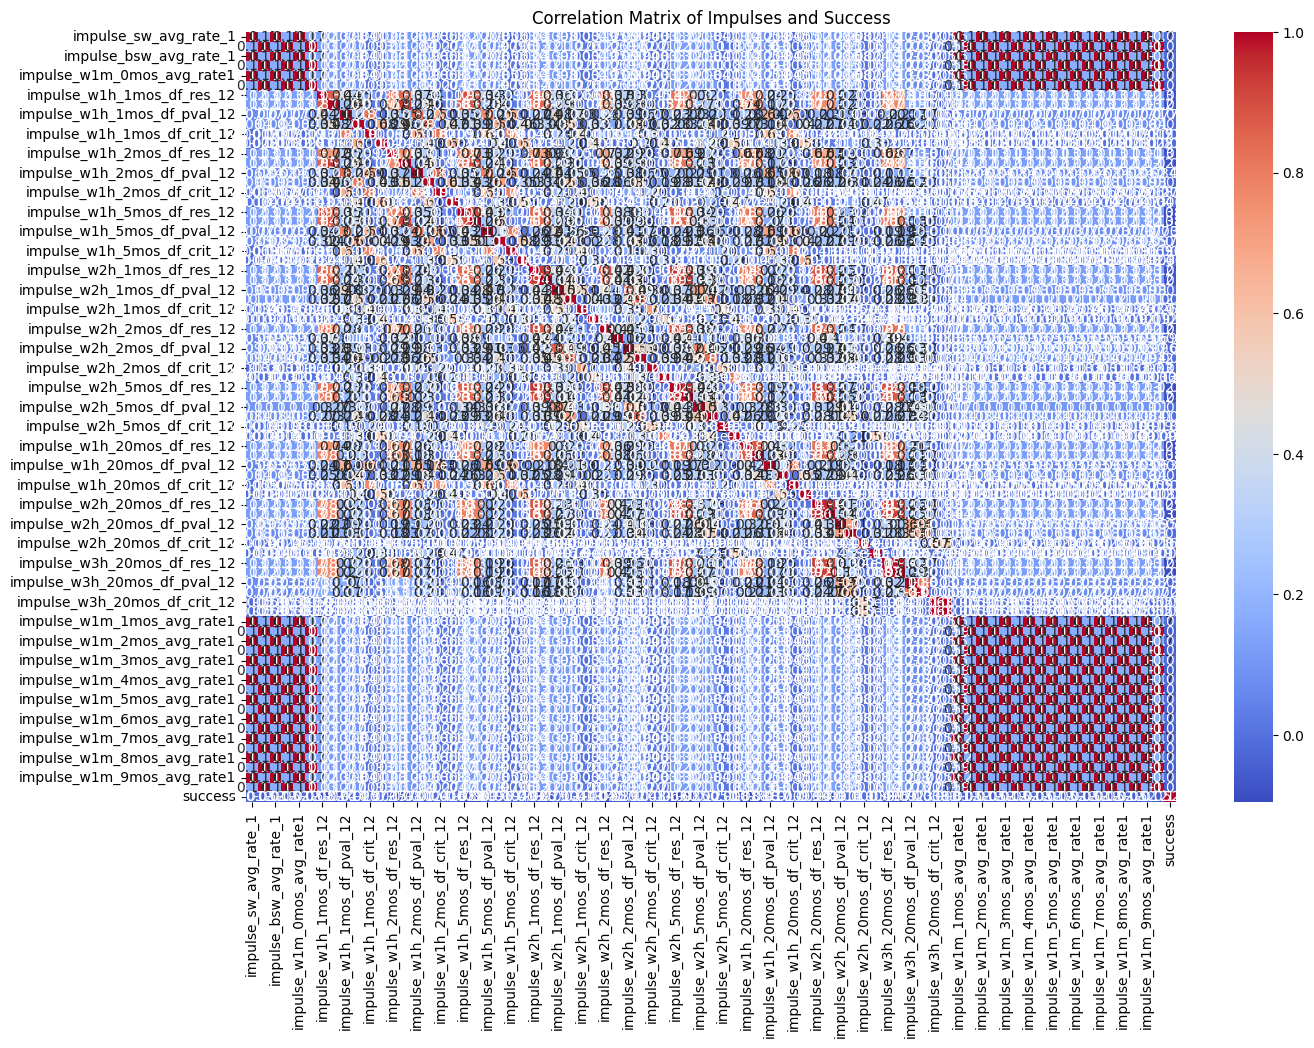

In [18]:
# Построение тепловой карты для визуализации корреляций
corr_matrix = df_impulses[impulse_columns + ['success']].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Impulses and Success')
plt.show()


In [ ]:
# Подготовка данных для обучения
X = df_impulses[impulse_columns].fillna(0)
y = df_impulses['success']

# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение моделей
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(kernel='linear', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Оценка моделей
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[model_name] = classification_report(y_test, y_pred, output_dict=True)

# Отображение результатов
results_df = pd.DataFrame(results).transpose()
results_df

,False,True,accuracy,macro avg,weighted avg
RandomForest,"{'precision': 0.7306791569086651, 'recall': 0....","{'precision': 0.7462616086888084, 'recall': 0....",0.738707,"{'precision': 0.7384703827987368, 'recall': 0....","{'precision': 0.7387047956448334, 'recall': 0...."
LogisticRegression,"{'precision': 0.5820224719101124, 'recall': 0....","{'precision': 0.5617343262070622, 'recall': 0....",0.568324,"{'precision': 0.5718783990585873, 'recall': 0....","{'precision': 0.57157319663965, 'recall': 0.56..."
SVC,"{'precision': 0.5809322033898305, 'recall': 0....","{'precision': 0.5377595025574166, 'recall': 0....",0.546022,"{'precision': 0.5593458529736235, 'recall': 0....","{'precision': 0.5586963893450118, 'recall': 0...."
GradientBoosting,"{'precision': 0.7094854742737137, 'recall': 0....","{'precision': 0.7089315399727973, 'recall': 0....",0.709188,"{'precision': 0.7092085071232554, 'recall': 0....","{'precision': 0.7092001740754232, 'recall': 0...."


In [ ]:
# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Повторная оценка моделей с нормализованными данными
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
results_scaled = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results_scaled[model_name] = classification_report(y_test, y_pred, output_dict=True)

# Отображение результатов с нормализованными данными
results_scaled_df = pd.DataFrame(results_scaled).transpose()
results_scaled_df


,False,True,accuracy,macro avg,weighted avg
RandomForest,"{'precision': 0.7249957976130442, 'recall': 0....","{'precision': 0.7387966154810405, 'recall': 0....",0.732139,"{'precision': 0.7318962065470423, 'recall': 0....","{'precision': 0.7321038175854426, 'recall': 0...."
LogisticRegression,"{'precision': 0.5658441241143416, 'recall': 0....","{'precision': 0.5552318523913571, 'recall': 0....",0.558754,"{'precision': 0.5605379882528494, 'recall': 0....","{'precision': 0.5603783437467579, 'recall': 0...."
SVC,"{'precision': 0.5571002979145978, 'recall': 0....","{'precision': 0.5291266841135989, 'recall': 0....",0.533696,"{'precision': 0.5431134910140983, 'recall': 0....","{'precision': 0.5426926731274643, 'recall': 0...."
GradientBoosting,"{'precision': 0.6787414965986395, 'recall': 0....","{'precision': 0.6916757091923733, 'recall': 0....",0.685508,"{'precision': 0.6852086028955064, 'recall': 0....","{'precision': 0.685403177255748, 'recall': 0.6..."


In [ ]:
# Определение важности признаков
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Отображение важности признаков
feature_importances


,Feature,Importance
1,impulse_sw_avg_rate_2,0.030150
2,impulse_bsw_avg_rate_1,0.026907
5,impulse_w1m_0mos_avg_rate2,0.025978
0,impulse_sw_avg_rate_1,0.025888
3,impulse_bsw_avg_rate_2,0.023382
...,...,...
52,impulse_w2h_20mos_df_crit_12,0.000033
40,impulse_w2h_5mos_df_crit_12,0.000033
35,impulse_w2h_2mos_df_crit_21,0.000033
29,impulse_w2h_1mos_df_crit_21,0.000033
